# Saving and Loading Models

In this notebook, we'll see how to save and load models with TensorFlow. This is important because you'll often want to load previously trained models to use in making predictions or to continue training on new data.

## Import Resources

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

In [3]:
import logging

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.9.1
	• tf.keras version: 2.9.0
	• GPU device not found. Running on CPU


2022-08-18 12:08:47.803824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the Dataset

In [5]:
splits = ['train[:80%]', 'train[80%:]', 'test']

dataset, dataset_info = tfds.load('fashion_mnist', split=splits, as_supervised=True, with_info=True)

training_set, validation_set, test_set = dataset

## Explore the Dataset

In [6]:
num_training_examples = len(training_set)
num_validation_examples = len(validation_set)
num_test_examples = len(test_set)

print(f'There are {num_training_examples:,} images in the training set')
print(f'There are {num_validation_examples:,} images in the validation set')
print(f'There are {num_test_examples:,} images in the test set')

There are 48,000 images in the training set
There are 12,000 images in the validation set
There are 10,000 images in the test set


In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

2022-08-18 12:08:48.012897: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


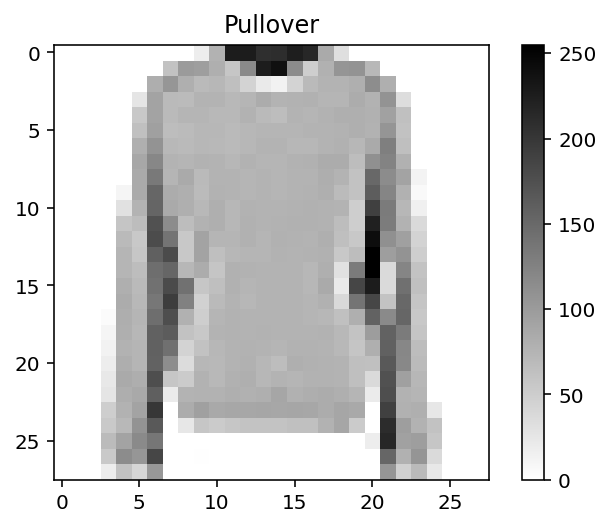

In [8]:
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image, cmap=plt.cm.binary)
plt.title(class_names[label])
plt.colorbar()
plt.show()

## Create Pipeline

In [9]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label


batch_size = 64

training_batches = training_set.cache().shuffle(num_training_examples // 4).batch(batch_size).map(normalize).prefetch(1)
validation_batches = validation_set.cache().batch(batch_size).map(normalize).prefetch(1)
testing_batches = test_set.cache().batch(batch_size).map(normalize).prefetch(1)

## Build and Train the Model

Here we'll build and compile our model as usual.

In [10]:
layer_neurons = [512, 256, 128]

dropout_rate = 0.5

model = tf.keras.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 1)))

for neurons in layer_neurons:
    model.add(tf.keras.layers.Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))

model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 4

history = model.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/4
750/750 [==============================] - 6s 7ms/step - loss: 0.8081 - accuracy: 0.7032 - val_loss: 0.4774 - val_accuracy: 0.8282
Epoch 2/4
750/750 [==============================] - 3s 4ms/step - loss: 0.5573 - accuracy: 0.8037 - val_loss: 0.4129 - val_accuracy: 0.8446
Epoch 3/4
750/750 [==============================] - 4s 5ms/step - loss: 0.5122 - accuracy: 0.8212 - val_loss: 0.3895 - val_accuracy: 0.8540
Epoch 4/4
750/750 [==============================] - 3s 5ms/step - loss: 0.4843 - accuracy: 0.8314 - val_loss: 0.3779 - val_accuracy: 0.8612


## Saving and Loading Models

In TensorFlow we can save our trained models in different formats. Here we will see how to save our models in TensorFlow's SavedModel format and as HDF5 files, which is the format used by Keras models.

### Saving and Loading Models in HDF5 Format

To save our models in the format used by Keras models we use the `.save(filepath)` method. For example, to save a model called `my_model` in the current working directory with the name `test_model` we use:

```python
my_model.save('./test_model.h5')
```

It's important to note that we have to provide the `.h5` extension to the `filepath` in order the tell `tf.keras` to save our model as an HDF5 file. 

The above command saves our model into a single HDF5 file that will contain:

* The model's architecture.
* The model's weight values which were learned during training.
* The model's training configuration, which corresponds to the parameters you passed to the `compile` method.
* The optimizer and its state. This allows you to resume training exactly where you left off.


In the cell below we save our trained `model` as an HDF5 file. The name of our HDF5 will correspond to the current time stamp. This is useful if you are saving many models and want each of them to have a unique name. By default the `.save()` method will **silently** overwrite any existing file at the target location with the same name. If we want `tf.keras` to provide us with a manual prompt to whether overwrite files with the same name, you can set the argument `overwrite=False` in the `.save()` method.

In [15]:
t = time.time()

saved_keras_model_filepath = f'./Part_6/hdf5/{int(t)}.h5'

model.save(saved_keras_model_filepath)

Once a model has been saved, we can use `tf.keras.models.load_model(filepath)` to re-load our model. This command will also compile our model automatically using the saved training configuration, unless the model was never compiled in the first place.

In [16]:
reloaded_keras_model = tf.keras.models.load_model(saved_keras_model_filepath)

reloaded_keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

As we can see the re-loaded model has the same architecture as our original model, as it should be. At this point, since we haven't done anything new to the re-loaded model, then both the `reloaded_keras_model` and our original `model` should be identical copies. Therefore, they should make the same predictions on the same images. Let's check that this is true:

In [17]:
for image_batch, label_batch in testing_batches.take(1):
    prediction_1 = model.predict(image_batch)
    prediction_2 = reloaded_keras_model.predict(image_batch)
    difference = np.abs(prediction_1 - prediction_2)
    print(difference.max())

2/2 [==============================] - 0s 3ms/step
0.0


2022-08-18 12:19:05.015559: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-08-18 12:19:05.015876: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


As we can see, the result is 0.0, which indicates that both models made the same predictions on the same images.

### Saving and Loading TensorFlow SavedModels

To export our models to the TensorFlow **SavedModel** format, we use the `tf.keras.models.save_model(model, export_dir)` function—but with path to the directory, not to the filename! For example, to save a model called `my_model` in a folder called `saved_models` located in the current working directory we use:

```python
tf.keras.models.save_model(my_model, './saved_models')

# Deprecated: Don't do this. It doesn't save the keras metadata, so the model will be loadable
# only via TensorFlow, yet not via Keras!
tf.saved_model.save(my_model, './saved_models')
```

It's important to note that here we have to provide the path to the directory where we want to save our model, **NOT** the name of the file. This is because SavedModels are not saved in a single file. Rather, when you save your model as a SavedModel, the `tf.saved_model.save()` function will create an `assets` folder, a `variables` folder, and a `saved_model.pb` file inside the directory you provided.

The SavedModel files that are created contain:

* A TensorFlow checkpoint containing the model weights.
* A SavedModel proto containing the underlying TensorFlow graph. Separate graphs are saved for prediction (serving), training, and evaluation. If the model wasn't compiled before, then only the inference graph gets exported.
* The model's architecture configuration if available.

The SavedModel is a standalone serialization format for TensorFlow objects, supported by TensorFlow serving as well as TensorFlow implementations other than Python. It does not require the original model building code to run, which makes it useful for sharing or deploying in different platforms, such as mobile and embedded devices (with TensorFlow Lite), servers (with TensorFlow Serving), and even web browsers (with TensorFlow.js).

In the cell below we save our trained model as a SavedModel. The name of the folder where we are going to save our model will correspond to the current time stamp. Again, this is useful if you are saving many models and want each of them to be saved in a unique directory.

In [29]:
t = time.time()

savedModel_directory = f'./Part_6/saved_models/{int(t)}'

# Don't do this, or you can only load it with tf.saved_model.load() yet not with tf.keras.models.load_model()
# tf.saved_model.save(model, savedModel_directory)

# Instead, save the model in the protobuf format via keras. That way, you can load it with both tf.saved_model.load() and tg.keras.models.load_model()
tf.keras.models.save_model(model, savedModel_directory)

Once a model has been saved as a SavedModel, we can use `tf.saved_model.load(export_dir)` to re-load our model. 

In [30]:
reloaded_SavedModel = tf.saved_model.load(savedModel_directory)

It's important to note that the object returned by `tf.saved_model.load` is **NOT** a Keras object. Therefore, it doesn't have `.fit`, `.predict`, `.summary`, etc. methods. It is 100% independent of the code that created it. This means that in order to make predictions with our `reloaded_SavedModel` we need to use a different method than the one used with the re-loaded Keras model.

To make predictions on a batch of images with a re-loaded SavedModel we have to use:

```python
reloaded_SavedModel(image_batch, training=False)
```

This will return a tensor with the predicted label probabilities for each image in the batch. Again, since we haven't done anything new to this re-loaded SavedModel, then both the `reloaded_SavedModel` and our original `model` should be identical copies. Therefore, they should make the same predictions on the same images. Let's check that this is true:

In [31]:
for image_batch, label_batch in testing_batches.take(1):
    prediction_1 = model.predict(image_batch)
    prediction_2 = reloaded_SavedModel(image_batch, training=False).numpy()
    difference = np.abs(prediction_1 - prediction_2)
    print(difference.max())

2/2 [==============================] - 0s 4ms/step
2.3841858e-07


2022-08-18 13:38:05.605677: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-08-18 13:38:05.605900: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


We can also get back a full Keras model, from a TensorFlow SavedModel, by loading our SavedModel with the `tf.keras.models.load_model` function. 

In [32]:
reloaded_keras_model_from_SavedModel = tf.keras.models.load_model(savedModel_directory)

reloaded_keras_model_from_SavedModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

### Saving Models During Training

We have seen that when we train a model with a validation set, the value of the validation loss changes through the training process. Since the value of the validation loss is an indicator of how well our model will generalize to new data, it will be great if could save our model at each step of the training process and then only keep the version with the lowest validation loss. 

We can do this in `tf.keras` by using the following callback:

```python
tf.keras.callbacks.ModelCheckpoint('./best_model.h5', monitor='val_loss', save_best_only=True)
```
This callback will save the model as a Keras HDF5 file after every epoch. With the `save_best_only=True` argument, this callback will first check the validation loss of the latest model against the one previously saved. The callback will only save the latest model and overwrite the old one, if the latest model has a lower validation loss than the one previously saved. This will guarantee that will end up with the version of the model that achieved the lowest validation loss during training.

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Stop training when there is no improvement in the validation loss for 10 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Save the Model with the lowest validation loss
save_best = tf.keras.callbacks.ModelCheckpoint('./Part_6/hdf5/best_model.h5',
                                               monitor='val_loss',
                                               save_best_only=True)

history = model.fit(training_batches,
                    epochs=100,
                    validation_data=validation_batches,
                    callbacks=[early_stopping, save_best])

Epoch 1/100
750/750 [==============================] - 3s 3ms/step - loss: 0.5241 - accuracy: 0.8154 - val_loss: 0.4128 - val_accuracy: 0.8468
Epoch 2/100
750/750 [==============================] - 2s 3ms/step - loss: 0.3793 - accuracy: 0.8606 - val_loss: 0.3583 - val_accuracy: 0.8641
Epoch 3/100
750/750 [==============================] - 2s 3ms/step - loss: 0.3422 - accuracy: 0.8735 - val_loss: 0.3375 - val_accuracy: 0.8742
Epoch 4/100
750/750 [==============================] - 2s 3ms/step - loss: 0.3136 - accuracy: 0.8834 - val_loss: 0.3438 - val_accuracy: 0.8758
Epoch 5/100
750/750 [==============================] - 2s 3ms/step - loss: 0.2992 - accuracy: 0.8875 - val_loss: 0.3483 - val_accuracy: 0.8698
Epoch 6/100
750/750 [==============================] - 2s 3ms/step - loss: 0.2831 - accuracy: 0.8950 - val_loss: 0.2975 - val_accuracy: 0.8907
Epoch 7/100
750/750 [==============================] - 2s 3ms/step - loss: 0.2680 - accuracy: 0.9000 - val_loss: 0.3100 - val_accuracy: 0.8888

In [41]:
reloaded_best_model = tf.keras.models.load_model('./Part_6/hdf5/best_model.h5')

loss, accuracy = reloaded_best_model.evaluate(validation_batches)
print(f'Validation\t{loss = :.3f}, {accuracy = :.3f}\n')

loss, accuracy = reloaded_best_model.evaluate(testing_batches)
print(f'Test\t\t{loss = :.3f}, {accuracy = :.3f}')

188/188 [==============================] - 0s 2ms/step - loss: 0.2849 - accuracy: 0.8959
Validation	loss = 0.285, accuracy = 0.896

157/157 [==============================] - 0s 1ms/step - loss: 0.3372 - accuracy: 0.8887
Test		loss = 0.337, accuracy = 0.889
